In [2]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

# diffusionlab imports
from diffusionlab.dynamics import VariancePreservingProcess
from diffusionlab.losses import DiffusionLoss
from diffusionlab.vector_fields import VectorFieldType

# repo imports
from src.diffusion_mem_gen.models.gmm import (
    IsoHomGMMInitStrategy,
    iso_hom_gmm_create_initialization_parameters,
    IsoHomGMMSharedParametersEstimator,
)
from src.diffusion_mem_gen.utils.factories import compute_loss_factory
from investigating_diffusion_loss import AmbientDiffusionLoss

key = random.PRNGKey(0)

## Crossover Analysis: Finding when PMEM and Generalising losses are equal

This notebook varies both M and t_n values to find the crossover points where PMEM loss equals Generalising loss.

In [12]:
# Dimension and training samples
laboratory_d = 32*32  # data dimension
laboratory_N = 300  # number of training samples
laboratory_K = 40 # number of components in the GMM

u_means_variance = 0.06 ** (1/2)  # order 1, controls the variance of the means of the true distribution
sample_variance = 0.06  # isotropic variance for each component

# M values: range to search for crossover
M_values = np.linspace(10, laboratory_N, 10).astype(int)
print(f"M values: {M_values}")

# t_n values to vary
t_n_values = np.linspace(0.1, 0.9, 9)
print(f"t_n values: {t_n_values}")

# Time grid for evaluation
t_val_array = jnp.linspace(0.01, 0.99, 26)

# Lambda function (constant for now)
lambda_fn = lambda t: 1

M values: [ 10  42  74 106 138 171 203 235 267 300]
t_n values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [13]:
# Diffusion process
diffusion_process = VariancePreservingProcess()

# Ground-truth GMM params
key, sk = random.split(key)
true_means = random.normal(sk, (laboratory_K, laboratory_d)) * u_means_variance
equal_weighted_prior = jnp.array([1/laboratory_K for _ in range(laboratory_K)])  # must sum to 1

# Sample training set from the true GMM
key, sk = random.split(key)
comp_ids = random.choice(sk, laboratory_K, shape=(laboratory_N,), p=equal_weighted_prior)
key, sk = random.split(key)
X_train = true_means[comp_ids] + jnp.sqrt(sample_variance) * random.normal(sk, (laboratory_N, laboratory_d))

print(f"Training data shape: {X_train.shape}")
print(f"True means shape: {true_means.shape}")

Training data shape: (300, 1024)
True means shape: (40, 1024)


In [14]:
# Build Generalizing denoiser (same for all M and t_n values)
generalising_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_K,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=true_means,
    init_var=jnp.asarray(sample_variance),
    priors=equal_weighted_prior,
)

print("Generalizing model created")

Generalizing model created


C:\Users\chris\AppData\Local\Temp\ipykernel_24108\3005088678.py:2: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  generalising_model = IsoHomGMMSharedParametersEstimator(


In [15]:
def L_N(model_callable, lambda_fn, t_val_array, t_n_value, X_0_dataset, X_t_n_dataset, key):
    '''
    This function computes the L_N loss for a given model and a given lambda function.
    '''
    ambient_loss_obj = AmbientDiffusionLoss(diffusion_process, num_noise_draws_per_sample=1, t_n=t_n_value)
    standard_loss_obj = DiffusionLoss(diffusion_process, vector_field_type=VectorFieldType.X0, num_noise_draws_per_sample=1)

    def L_N_t_ambient(model_callable, t_n_value, t_val, X_t_n_dataset, key):
        '''
        This function computes the L_N_t for the ambient denoising term.
        '''
        assert t_val > t_n_value
        
        compute_loss = compute_loss_factory(ambient_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(key, model_callable, X_t_n_dataset) / X_0_dataset.shape[0] 
        
        return loss_val

    def L_N_t_standard_score(model_callable, t_val, X_t_dataset, key):
        '''
        This function computes the L_N_t for the standard denoising term.
        '''
        compute_loss = compute_loss_factory(standard_loss_obj, jnp.array(t_val))
        loss_val = compute_loss(key, model_callable, X_t_dataset) / X_0_dataset.shape[0] 
        
        return loss_val
    
    # Split into less than t_n and greater than t_n
    less_than_n_mask = jnp.less_equal(t_val_array, t_n_value)
    greater_than_n_mask = jnp.logical_not(less_than_n_mask)

    standard_denoising_t_values = t_val_array[less_than_n_mask]
    ambient_denoising_t_values = t_val_array[greater_than_n_mask]
  
    # Compute the loss for the standard denoising term
    current_key = key
    standard_denoising_loss_values = []
    for t in standard_denoising_t_values:
        current_key, subk = random.split(current_key)
        loss_val = L_N_t_standard_score(model_callable, t, X_0_dataset, subk)
        standard_denoising_loss_values.append(lambda_fn(t) * loss_val)

    averaged_standard_denoising_loss = np.mean(standard_denoising_loss_values)

    # Compute the loss for the ambient denoising term
    ambient_denoising_loss_values = []
    for t in ambient_denoising_t_values:
        current_key, subk = random.split(current_key)
        loss_val = L_N_t_ambient(model_callable, t_n_value, t, X_t_n_dataset, subk)
        ambient_denoising_loss_values.append(lambda_fn(t) * loss_val)
    
    averaged_ambient_denoising_loss = np.mean(ambient_denoising_loss_values)

    return averaged_standard_denoising_loss + averaged_ambient_denoising_loss

In [16]:
def find_crossover_point(M_values, pmem_losses, generalising_losses):
    '''
    Find the M value where PMEM and Generalising losses cross over.
    Returns the M/N ratio at crossover, or None if no crossover found.
    '''
    loss_difference = pmem_losses - generalising_losses
    
    # Check if there's a sign change
    sign_changes = np.where(np.diff(np.sign(loss_difference)))[0]
    
    if len(sign_changes) == 0:
        # No sign change - check if we're close to zero
        min_abs_diff_idx = np.argmin(np.abs(loss_difference))
        min_abs_diff = np.abs(loss_difference[min_abs_diff_idx])
        
        # If we're very close to zero, return that point
        if min_abs_diff < 0.01:  # threshold for "close enough"
            return M_values[min_abs_diff_idx] / laboratory_N
        else:
            return None
    
    # Interpolate to find exact crossover point
    crossover_M_over_N = []
    for idx in sign_changes:
        # Linear interpolation between points
        x1, x2 = M_values[idx] / laboratory_N, M_values[idx + 1] / laboratory_N
        y1, y2 = loss_difference[idx], loss_difference[idx + 1]
        
        # Find where y = 0
        if y2 != y1:
            x_cross = x1 - y1 * (x2 - x1) / (y2 - y1)
            crossover_M_over_N.append(x_cross)
    
    # Return the first crossover point (or average if multiple)
    if len(crossover_M_over_N) > 0:
        return crossover_M_over_N[0]
    else:
        return None

In [17]:
# Store results for all (t_n, M) combinations
crossover_points = []  # (t_n, M/N at crossover)
all_results = {}  # Store full results for each t_n

# Evaluate for each t_n value
for t_n in t_n_values:
    print(f"\n{'='*60}")
    print(f"Processing t_n = {t_n:.2f}")
    print(f"{'='*60}")
    
    t_n_value = jnp.array(t_n)
    
    # Generate X_t_n_dataset for this t_n value
    key, subk = random.split(key)
    X_t_n_eps = jax.random.normal(subk, X_train.shape)
    batch_diffusion_forward = jax.vmap(
        diffusion_process.forward, in_axes=(0, None, 0)
    )
    X_t_n_dataset = batch_diffusion_forward(X_train, t_n_value, X_t_n_eps)
    
    # Store losses for this t_n
    pmem_losses = []
    generalising_losses = []
    M_over_N_values = []
    
    # Evaluate L_N for each M value
    for M in M_values:
        print(f"  M = {M:3d} (M/N = {M/laboratory_N:.2f})...", end=" ")
        
        # Build PMEM denoiser for this M value
        key, sk = random.split(key)
        context = {
            "X_train": X_train,
            "init_var_scale": 1e-6,
            "init_means_noise_var": 0.0,
        }
        means_pmem, var_pmem, priors_pmem = iso_hom_gmm_create_initialization_parameters(
            sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, M, context
        )
        
        pmem_model = IsoHomGMMSharedParametersEstimator(
            dim=laboratory_d,
            num_components=M,
            vf_type=VectorFieldType.X0,
            diffusion_process=diffusion_process,
            init_means=means_pmem,
            init_var=var_pmem,
            priors=priors_pmem,
        )
        
        # Evaluate L_N for PMEM model
        key, subk = random.split(key)
        pmem_loss = L_N(pmem_model, lambda_fn, t_val_array, t_n_value, X_train, X_t_n_dataset, subk)
        pmem_losses.append(float(pmem_loss))
        
        # Evaluate L_N for Generalizing model (same for all M)
        key, subk = random.split(key)
        generalising_loss = L_N(generalising_model, lambda_fn, t_val_array, t_n_value, X_train, X_t_n_dataset, subk)
        generalising_losses.append(float(generalising_loss))
        
        M_over_N = M / laboratory_N
        M_over_N_values.append(M_over_N)
        
        print(f"PMEM={pmem_loss:.4f}, Gen={generalising_loss:.4f}, Diff={pmem_loss-generalising_loss:.4f}")
    
    pmem_losses = np.array(pmem_losses)
    generalising_losses = np.array(generalising_losses)
    M_over_N_values = np.array(M_over_N_values)
    
    # Store results
    all_results[t_n] = {
        'M_over_N': M_over_N_values,
        'pmem_losses': pmem_losses,
        'generalising_losses': generalising_losses
    }
    
    # Find crossover point
    crossover_M_over_N = find_crossover_point(M_values, pmem_losses, generalising_losses)
    if crossover_M_over_N is not None:
        crossover_points.append((t_n, crossover_M_over_N))
        print(f"\n  ✓ Crossover found at M/N = {crossover_M_over_N:.4f}")
    else:
        print(f"\n  ✗ No crossover found in this range")

print(f"\n\nTotal crossover points found: {len(crossover_points)}")


Processing t_n = 0.10
  M =  10 (M/N = 0.03)... 

C:\Users\chris\AppData\Local\Temp\ipykernel_24108\1834767426.py:41: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  pmem_model = IsoHomGMMSharedParametersEstimator(


PMEM=1.2317, Gen=0.2038, Diff=1.0280
  M =  42 (M/N = 0.14)... PMEM=0.8634, Gen=0.2034, Diff=0.6600
  M =  74 (M/N = 0.25)... PMEM=0.6608, Gen=0.2034, Diff=0.4575
  M = 106 (M/N = 0.35)... PMEM=0.5297, Gen=0.2037, Diff=0.3260
  M = 138 (M/N = 0.46)... PMEM=0.4353, Gen=0.2039, Diff=0.2314
  M = 171 (M/N = 0.57)... PMEM=0.3566, Gen=0.2032, Diff=0.1534
  M = 203 (M/N = 0.68)... PMEM=0.2809, Gen=0.2036, Diff=0.0774
  M = 235 (M/N = 0.78)... PMEM=0.2053, Gen=0.2036, Diff=0.0017
  M = 267 (M/N = 0.89)... PMEM=0.1296, Gen=0.2036, Diff=-0.0739
  M = 300 (M/N = 1.00)... PMEM=0.0560, Gen=0.2033, Diff=-0.1473

  ✓ Crossover found at M/N = 0.7857

Processing t_n = 0.20
  M =  10 (M/N = 0.03)... PMEM=1.2357, Gen=0.2855, Diff=0.9501
  M =  42 (M/N = 0.14)... PMEM=0.8735, Gen=0.2860, Diff=0.5875
  M =  74 (M/N = 0.25)... PMEM=0.7089, Gen=0.2851, Diff=0.4237
  M = 106 (M/N = 0.35)... PMEM=0.5859, Gen=0.2855, Diff=0.3004
  M = 138 (M/N = 0.46)... PMEM=0.4869, Gen=0.2858, Diff=0.2011
  M = 171 (M/N = 0.

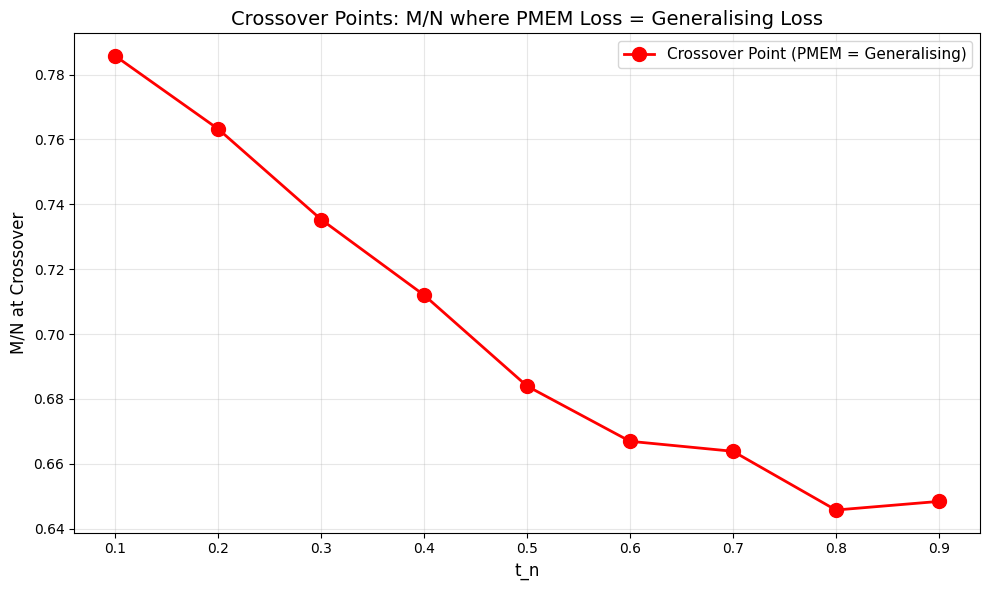


Crossover points (t_n, M/N):
  t_n = 0.10, M/N = 0.7857
  t_n = 0.20, M/N = 0.7632
  t_n = 0.30, M/N = 0.7353
  t_n = 0.40, M/N = 0.7120
  t_n = 0.50, M/N = 0.6839
  t_n = 0.60, M/N = 0.6669
  t_n = 0.70, M/N = 0.6638
  t_n = 0.80, M/N = 0.6457
  t_n = 0.90, M/N = 0.6484


In [18]:
# Plot the crossover points
if len(crossover_points) > 0:
    crossover_t_n = np.array([cp[0] for cp in crossover_points])
    crossover_M_over_N = np.array([cp[1] for cp in crossover_points])
    
    # Sort by t_n for plotting
    sort_idx = np.argsort(crossover_t_n)
    crossover_t_n = crossover_t_n[sort_idx]
    crossover_M_over_N = crossover_M_over_N[sort_idx]
    
    plt.figure(figsize=(10, 6))
    plt.plot(crossover_t_n, crossover_M_over_N, 'o-', linewidth=2, markersize=10, 
             label='Crossover Point (PMEM = Generalising)', color='red')
    plt.xlabel('t_n', fontsize=12)
    plt.ylabel('M/N at Crossover', fontsize=12)
    plt.title('Crossover Points: M/N where PMEM Loss = Generalising Loss', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    print(f"\nCrossover points (t_n, M/N):")
    for t_n, m_over_n in zip(crossover_t_n, crossover_M_over_N):
        print(f"  t_n = {t_n:.2f}, M/N = {m_over_n:.4f}")
else:
    print("No crossover points found. The losses may not cross in the evaluated range.")

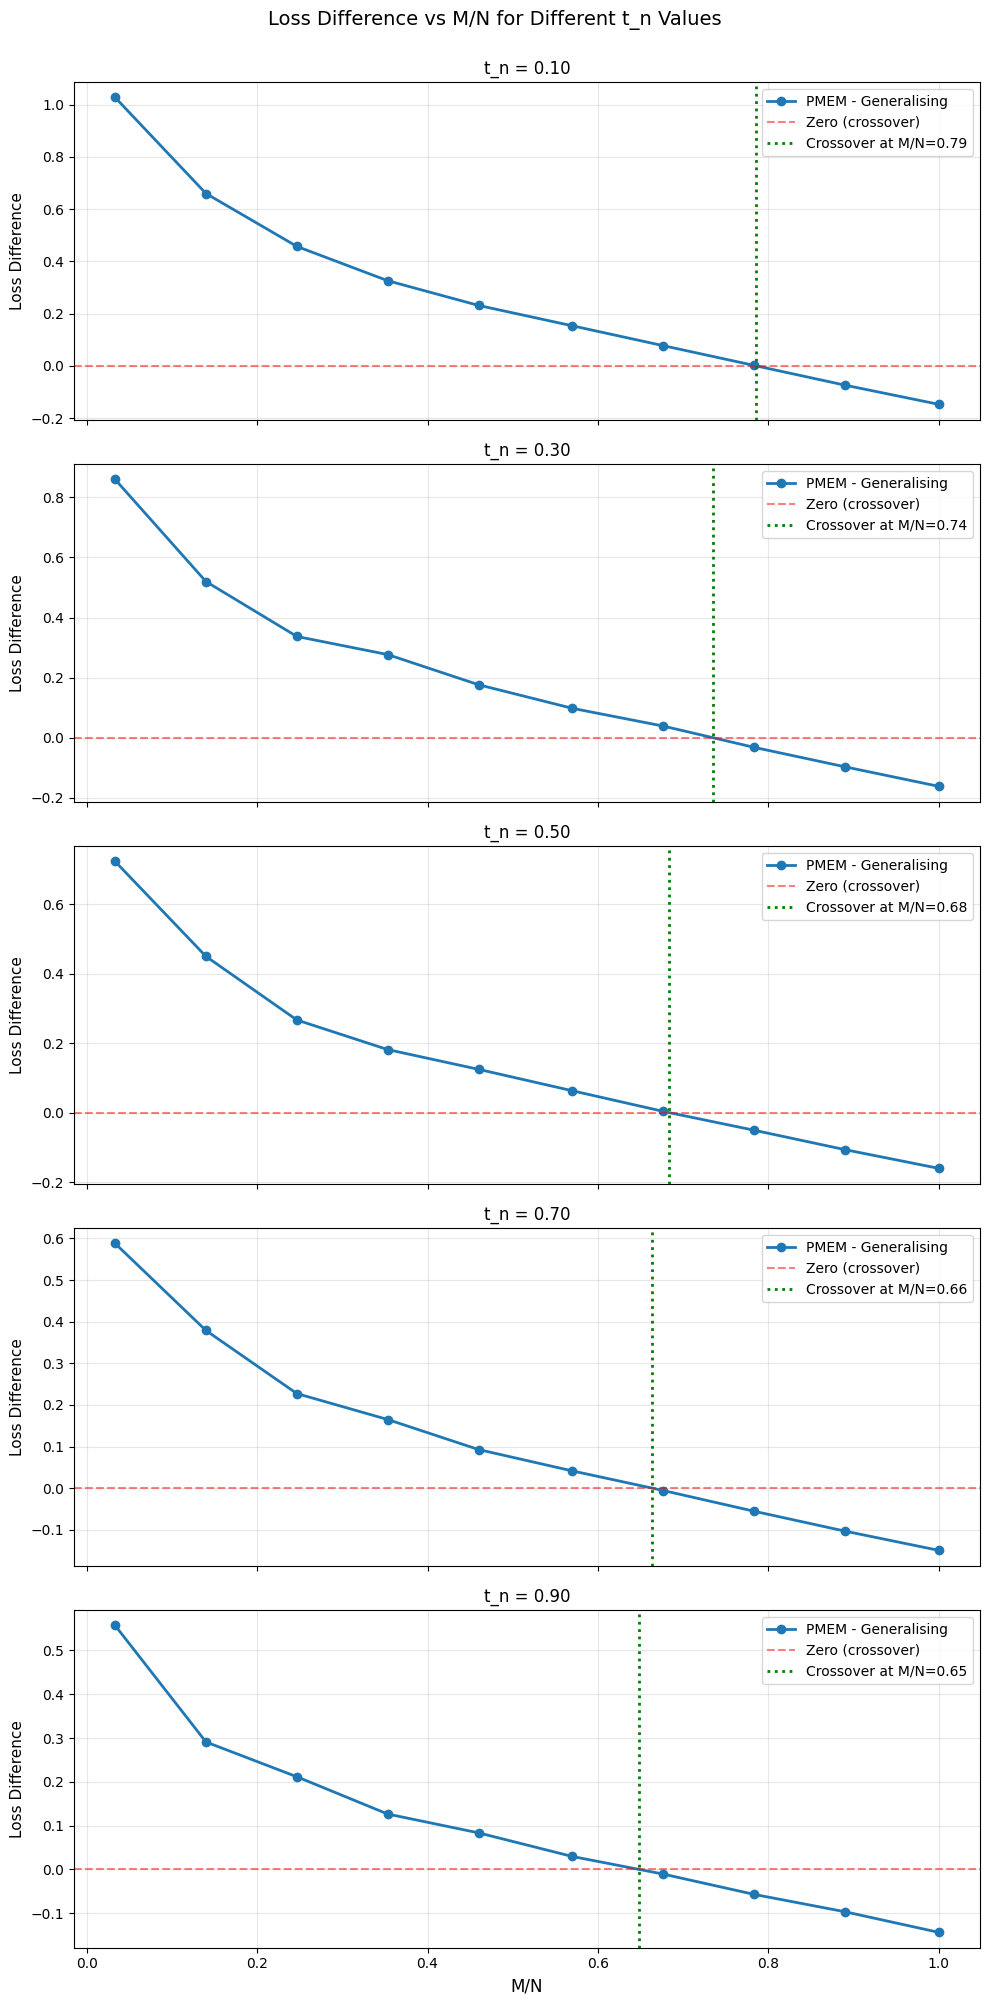

In [19]:
# Optional: Plot loss differences for a few selected t_n values to visualize the crossover
selected_t_n = t_n_values[::2]  # Every other t_n value

fig, axes = plt.subplots(len(selected_t_n), 1, figsize=(10, 4*len(selected_t_n)), sharex=True)

if len(selected_t_n) == 1:
    axes = [axes]

for idx, t_n in enumerate(selected_t_n):
    ax = axes[idx]
    results = all_results[t_n]
    
    loss_diff = results['pmem_losses'] - results['generalising_losses']
    
    ax.plot(results['M_over_N'], loss_diff, 'o-', linewidth=2, markersize=6, label='PMEM - Generalising')
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Zero (crossover)')
    ax.set_ylabel('Loss Difference', fontsize=11)
    ax.set_title(f't_n = {t_n:.2f}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Mark crossover point if it exists
    crossover_M_over_N = find_crossover_point(M_values, results['pmem_losses'], results['generalising_losses'])
    if crossover_M_over_N is not None:
        ax.axvline(x=crossover_M_over_N, color='green', linestyle=':', linewidth=2, 
                  label=f'Crossover at M/N={crossover_M_over_N:.2f}')
        ax.legend(fontsize=10)

axes[-1].set_xlabel('M/N', fontsize=12)
plt.suptitle('Loss Difference vs M/N for Different t_n Values', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

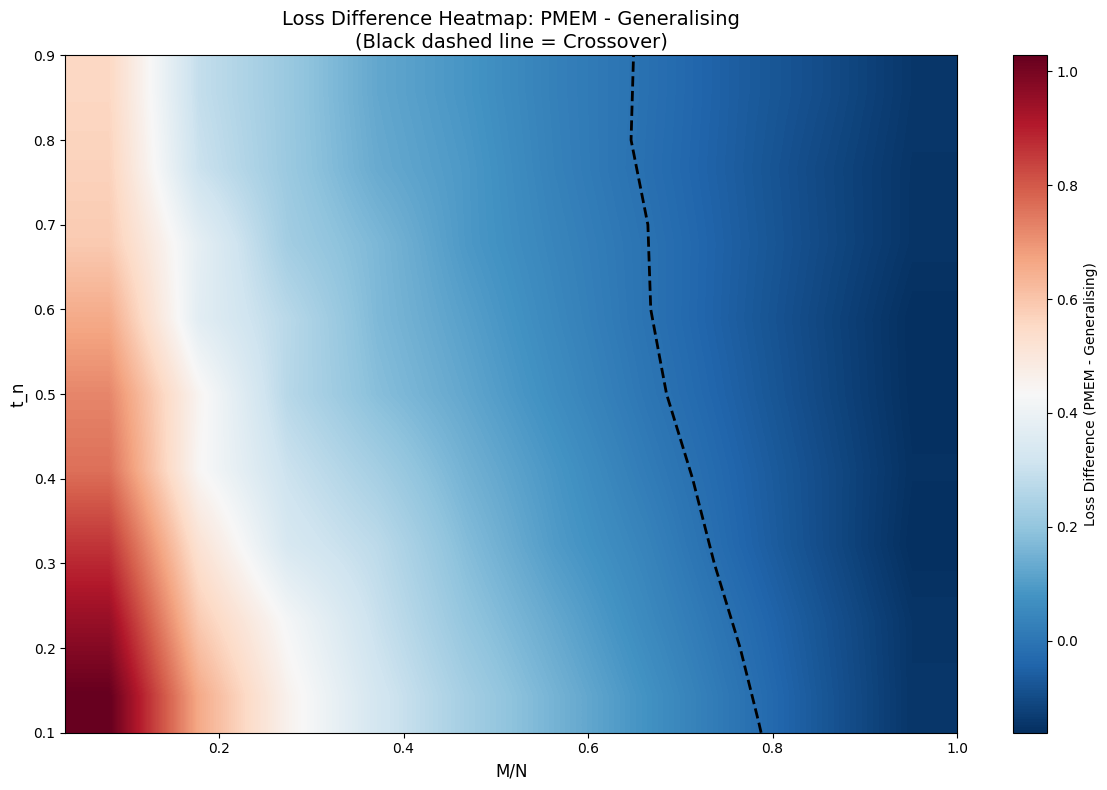

In [20]:
# Create a heatmap showing loss difference across M/N and t_n
M_over_N_grid = np.linspace(M_values.min() / laboratory_N, M_values.max() / laboratory_N, len(M_values))
t_n_grid = t_n_values

# Create a grid of loss differences
loss_diff_grid = np.zeros((len(t_n_values), len(M_values)))

for i, t_n in enumerate(t_n_values):
    results = all_results[t_n]
    loss_diff_grid[i, :] = results['pmem_losses'] - results['generalising_losses']

# Plot heatmap
plt.figure(figsize=(12, 8))
im = plt.imshow(loss_diff_grid, aspect='auto', origin='lower', 
                extent=[M_over_N_grid.min(), M_over_N_grid.max(), 
                       t_n_grid.min(), t_n_grid.max()],
                cmap='RdBu_r', interpolation='bilinear')
plt.colorbar(im, label='Loss Difference (PMEM - Generalising)')
plt.contour(M_over_N_grid, t_n_grid, loss_diff_grid, levels=[0], colors='black', linewidths=2, linestyles='--')
plt.xlabel('M/N', fontsize=12)
plt.ylabel('t_n', fontsize=12)
plt.title('Loss Difference Heatmap: PMEM - Generalising\n(Black dashed line = Crossover)', fontsize=14)
plt.tight_layout()
plt.show()